# Computational Tomography with Un-trained Neural Networks

In this exercise, the task is to reconstruct an image in the context of computational tomography. The original images is given as $x$ below, and is loaded from the the file origina.npy, which must be in the same folder as this notebook.

Below, you are given the measurement operator $A$ and a measurement obtained as
$$
y = A x.
$$
The task is to reconstruct the image $x$ from $y$ with an un-trained neural network. You are welcome to use code from any repository of your choice, for example:
- Deep image prior: [https://github.com/DmitryUlyanov/deep-image-prior](https://github.com/DmitryUlyanov/deep-image-prior)
- Deep decoder: [https://github.com/reinhardh/supplement_deep_decoder](https://github.com/reinhardh/supplement_deep_decoder)
- Compressive sensing with the deep decoder [https://github.com/MLI-lab/cs_deep_decoder](https://github.com/MLI-lab/cs_deep_decoder)
To make this work, you might have to tune the network and optimization appropriately.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.functional as F
from torch.autograd import Variable
import torch.nn as nn
import copy
import os
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)
from pathlib import Path

In [2]:
#Load ground truth

x_path='./original.npy'  #path to ground truth
x=np.load(x_path)        #load ground truth

device = torch.device("cuda")
x=torch.FloatTensor(x)

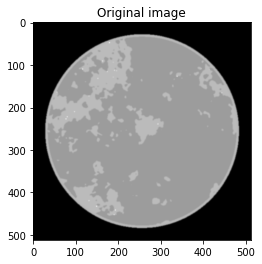

In [3]:
#Plot original image

plt.imshow(x)
plt.gray()
plt.title('Original image')
plt.show()

In the following we define the forward model $A$, which represents a parallel beam projection (also known as a discrete radon transform) with a 4x acceleration factor.

In [4]:
#Forward Model A

def A(image):
    n=image.shape[0]
    m=n//4  # 4 times acceleration
    pbp = torch.zeros(m,n)
    image=image.unsqueeze(0)
    
    for i in range(m):
        proj = F.rotate(image, -i*180/m).squeeze(0)
        pbp[i,:] = torch.sum(proj,0)
        
    return pbp

The measurement, $y$, is created by: $y=A(x)$

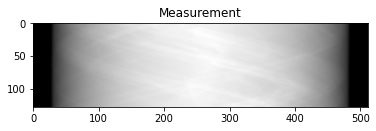

In [5]:
#create and plot measurement
y=A(x)

plt.imshow(y)
plt.title('Measurement')
plt.show()

In [6]:
def np_to_var(img_np, dtype=torch.cuda.FloatTensor):
    '''Converts image in numpy.array to torch.Variable.

    From C x W x H [0..1] to  1 x C x W x H [0..1]
    '''
    return Variable(torch.from_numpy(img_np)[None, :])

def psnr(x_hat, x_true, maxv=1.):
    x_hat = x_hat.flatten()
    x_true = x_true.flatten()
    mse = np.mean(np.square(x_hat - x_true))
    psnr_ = 10. * np.log(maxv ** 2 / mse) / np.log(10.)
    return psnr_


def num_param(net):
    s = sum([np.prod(list(p.size())) for p in net.parameters()])
    return s


def myimgshow(plt, img):
    if (img.shape[0] == 1):
        plt.imshow(np.clip(img[0], 0, 1), cmap='Greys', interpolation='none')
    else:
        plt.imshow(np.clip(img.transpose(1, 2, 0), 0, 1), interpolation='none')


def add_module(self, module):
    self.add_module(str(len(self) + 1), module)


def conv(in_f, out_f, kernel_size, stride=1, pad='zero'):
    padder = None
    to_pad = int((kernel_size - 1) / 2)
    if pad == 'reflection':
        padder = nn.ReflectionPad2d(to_pad)
        to_pad = 0

    convolver = nn.Conv2d(in_f, out_f, kernel_size, stride, padding=to_pad, bias=False)

    layers = filter(lambda x: x is not None, [padder, convolver])
    return nn.Sequential(*layers)

In [7]:
torch.nn.Module.add = add_module

In [8]:
def decodernw(
        num_output_channels=3,
        num_channels_up=[128] * 5,
        filter_size_up=1,
        need_sigmoid=True,
        pad='reflection',
        upsample_mode='bilinear',
        act_fun=nn.ReLU(),  # nn.LeakyReLU(0.2, inplace=True)
        bn_before_act=False,
        bn_affine=True,
        upsample_first=True,
):
    num_channels_up = num_channels_up + [num_channels_up[-1], num_channels_up[-1]]
    n_scales = len(num_channels_up)

    if not (isinstance(filter_size_up, list) or isinstance(filter_size_up, tuple)):
        filter_size_up = [filter_size_up] * n_scales
    model = nn.Sequential()

    for i in range(len(num_channels_up) - 1):

        if upsample_first:
            model.add(conv(num_channels_up[i], num_channels_up[i + 1], filter_size_up[i], 1, pad=pad))
            if upsample_mode != 'none' and i != len(num_channels_up) - 2:
                model.add(nn.Upsample(scale_factor=2, mode=upsample_mode))
            # model.add(nn.functional.interpolate(size=None,scale_factor=2, mode=upsample_mode))
        else:
            if upsample_mode != 'none' and i != 0:
                model.add(nn.Upsample(scale_factor=2, mode=upsample_mode))
            # model.add(nn.functional.interpolate(size=None,scale_factor=2, mode=upsample_mode))
            model.add(conv(num_channels_up[i], num_channels_up[i + 1], filter_size_up[i], 1, pad=pad))

        if i != len(num_channels_up) - 1:
            if (bn_before_act):
                model.add(nn.BatchNorm2d(num_channels_up[i + 1], affine=bn_affine))
            model.add(act_fun)
            if (not bn_before_act):
                model.add(nn.BatchNorm2d(num_channels_up[i + 1], affine=bn_affine))

    model.add(conv(num_channels_up[-1], num_output_channels, 1, pad=pad))
    if need_sigmoid:
        model.add(nn.Sigmoid())

    return model

In [9]:
def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=500):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.65 ** (epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

In [10]:
def fit(net,
        img_noisy_var,
        num_channels,
        img_clean_var,
        num_iter=5000,
        LR=0.01,
        OPTIMIZER='adam',
        opt_input=False,
        reg_noise_std=0,
        reg_noise_decayevery=100000,
        mask_var=None,
        apply_f=None,
        lr_decay_epoch=0,
        net_input=None,
        net_input_gen="random",
        find_best=False,
        weight_decay=0,
        ):
    if net_input is not None:
        print("input provided")
    else:
        # feed uniform noise into the network
        totalupsample = 2 ** len(num_channels)
        width = int(img_clean_var.data.shape[2] / totalupsample)
        height = int(img_clean_var.data.shape[3] / totalupsample)
        shape = [1, num_channels[0], width, height]
        print("shape: ", shape)
        net_input = Variable(torch.randn(shape)/(num_channels[0] * width * height) ** 0.5)
        # net_input = Variable(torch.zeros(shape))
        # net_input.data.uniform_()
        # net_input.data *= 1. / 10

    net_input_saved = net_input.data.clone()
    noise = net_input.data.clone()
    p = [x for x in net.parameters()]

    if (opt_input == True):  # optimizer over the input as well
        net_input.requires_grad = True
        p += [net_input]

    mse_wrt_noisy = np.zeros(num_iter)
    mse_wrt_truth = np.zeros(num_iter)

    if OPTIMIZER == 'SGD':
        print("optimize with SGD", LR)
        optimizer = torch.optim.SGD(p, lr=LR, momentum=0.9, weight_decay=weight_decay)
    elif OPTIMIZER == 'adam':
        print("optimize with adam", LR)
        optimizer = torch.optim.Adam(p, lr=LR, weight_decay=weight_decay)
    elif OPTIMIZER == 'LBFGS':
        print("optimize with LBFGS", LR)
        optimizer = torch.optim.LBFGS(p, lr=LR)

    mse = torch.nn.MSELoss()  # .type(dtype)
    noise_energy = mse(img_noisy_var, img_noisy_var)

    if find_best:
        best_net = copy.deepcopy(net)
        best_mse = 1000000.0
    for i in tqdm(range(num_iter)):
        if lr_decay_epoch is not 0:
            optimizer = exp_lr_scheduler(optimizer, i, init_lr=LR, lr_decay_epoch=lr_decay_epoch)
        if reg_noise_std > 0:
            if i % reg_noise_decayevery == 0:
                reg_noise_std *= 0.7
            net_input = Variable(net_input_saved + (noise.normal_() * reg_noise_std))

        def closure():
            optimizer.zero_grad()
            out = net(net_input.type(dtype))
            out_img = out.clone()
            folder_path = './images_out'
            Path(folder_path).mkdir(parents=True, exist_ok=True)
            # training loss
            if mask_var is not None:
                loss = mse(out * mask_var, img_noisy_var * mask_var)
            elif apply_f:
                temp = apply_f(torch.squeeze(out)).unsqueeze(0).unsqueeze(0).to(device)
                loss = mse(temp, img_noisy_var)
            else:
                loss = mse(out, img_noisy_var)

            loss.backward()
            mse_wrt_noisy[i] = loss.data.cpu().numpy()

            # the actual loss
            true_loss = mse(Variable(out.data, requires_grad=False), img_clean_var)
            # print(true_loss)
            mse_wrt_truth[i] = true_loss.data.cpu().numpy()
            if i % 1000 == 0:
                image_path = os.path.join(folder_path, f"kk_{i//100}.png")
                plt.imshow(out_img.detach().cpu().numpy().squeeze(), cmap="gray")
                plt.savefig(image_path)
                plt.close()
                print(i, i % 100 == 0)
                out2 = net(Variable(net_input_saved).type(dtype))
                loss2 = mse(out2, img_clean_var)
                print('Iteration %05d    Train loss %f  Actual loss %f Actual loss orig %f  Noise Energy %f' % (i,
                                                                                                                loss.data,
                                                                                                                true_loss.data,
                                                                                                                loss2.data,
                                                                                                                noise_energy.data))
            return loss

        loss = optimizer.step(closure)

        if find_best:
            # if training loss improves by at least one percent, we found a new best net
            if best_mse > 1.005 * loss.data:
                best_mse = loss.data
                best_net = copy.deepcopy(net)

    if find_best:
        net = best_net
    return mse_wrt_noisy, mse_wrt_truth, net_input_saved, net

In [11]:
def run(x_np, y_np, k):
    '''
    mse obtained by representing img_np with the deep decoder
    '''
    output_depth = x_np.shape[0]
    x_var = np_to_var(x_np).type(dtype)
    y_var = np_to_var(y_np).type(dtype)

    num_channels = [k] * 5
    net = decodernw(output_depth, num_channels_up=num_channels, upsample_first=True).type(dtype)
    numit = 25000
    mse_n, mse_t, ni, net = fit(num_channels=num_channels,
                                reg_noise_std=0,
                                num_iter=numit,
                                LR=0.001,
                                img_noisy_var=y_var,
                                net=net,
                                img_clean_var=x_var,
                                find_best=True,
                                apply_f=A,
                                OPTIMIZER='adam'
                                )
    out_img = net(ni.type(dtype)).data.cpu().numpy()[0]
    return psnr(out_img, x_np), out_img, num_param(net)

num GPUs 1


  0%|          | 0/25000 [00:00<?, ?it/s]

shape:  [1, 64, 16, 16]
optimize with adam 0.001


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
  0%|          | 1/25000 [00:00<3:32:30,  1.96it/s]

0 True
Iteration 00000    Train loss 27865.277344  Actual loss 0.172980 Actual loss orig 0.172980  Noise Energy 0.000000


  4%|▍         | 1003/25000 [01:28<39:35, 10.10it/s]

1000 True
Iteration 01000    Train loss 23.881077  Actual loss 0.013330 Actual loss orig 0.013330  Noise Energy 0.000000


  8%|▊         | 2003/25000 [02:55<40:25,  9.48it/s]

2000 True
Iteration 02000    Train loss 7.505500  Actual loss 0.006169 Actual loss orig 0.006169  Noise Energy 0.000000


 12%|█▏        | 3003/25000 [04:21<36:08, 10.14it/s]

3000 True
Iteration 03000    Train loss 4.929256  Actual loss 0.004557 Actual loss orig 0.004557  Noise Energy 0.000000


 16%|█▌        | 4003/25000 [05:48<34:34, 10.12it/s]

4000 True
Iteration 04000    Train loss 1.820753  Actual loss 0.003114 Actual loss orig 0.003114  Noise Energy 0.000000


 20%|██        | 5003/25000 [07:14<32:34, 10.23it/s]

5000 True
Iteration 05000    Train loss 1.742005  Actual loss 0.002524 Actual loss orig 0.002524  Noise Energy 0.000000


 24%|██▍       | 6003/25000 [08:41<30:42, 10.31it/s]

6000 True
Iteration 06000    Train loss 0.751432  Actual loss 0.001429 Actual loss orig 0.001429  Noise Energy 0.000000


 28%|██▊       | 7003/25000 [10:07<29:43, 10.09it/s]

7000 True
Iteration 07000    Train loss 0.291602  Actual loss 0.000837 Actual loss orig 0.000837  Noise Energy 0.000000


 32%|███▏      | 8003/25000 [11:34<27:28, 10.31it/s]

8000 True
Iteration 08000    Train loss 0.186826  Actual loss 0.000467 Actual loss orig 0.000467  Noise Energy 0.000000


 36%|███▌      | 9003/25000 [13:00<26:20, 10.12it/s]

9000 True
Iteration 09000    Train loss 0.106551  Actual loss 0.000270 Actual loss orig 0.000270  Noise Energy 0.000000


 40%|████      | 10003/25000 [14:27<24:28, 10.21it/s]

10000 True
Iteration 10000    Train loss 2.578211  Actual loss 0.002337 Actual loss orig 0.002337  Noise Energy 0.000000


 44%|████▍     | 11003/25000 [15:53<23:03, 10.11it/s]

11000 True
Iteration 11000    Train loss 0.343185  Actual loss 0.000413 Actual loss orig 0.000413  Noise Energy 0.000000


 48%|████▊     | 12003/25000 [17:19<21:02, 10.29it/s]

12000 True
Iteration 12000    Train loss 0.194456  Actual loss 0.000368 Actual loss orig 0.000368  Noise Energy 0.000000


 52%|█████▏    | 13003/25000 [18:45<19:28, 10.27it/s]

13000 True
Iteration 13000    Train loss 0.108375  Actual loss 0.000180 Actual loss orig 0.000180  Noise Energy 0.000000


 56%|█████▌    | 14003/25000 [20:12<18:21,  9.98it/s]

14000 True
Iteration 14000    Train loss 1.075710  Actual loss 0.000219 Actual loss orig 0.000219  Noise Energy 0.000000


 60%|██████    | 15003/25000 [21:38<16:23, 10.16it/s]

15000 True
Iteration 15000    Train loss 0.379786  Actual loss 0.000102 Actual loss orig 0.000102  Noise Energy 0.000000


 64%|██████▍   | 16003/25000 [23:04<14:37, 10.25it/s]

16000 True
Iteration 16000    Train loss 0.228663  Actual loss 0.000069 Actual loss orig 0.000069  Noise Energy 0.000000


 68%|██████▊   | 17003/25000 [24:31<14:08,  9.42it/s]

17000 True
Iteration 17000    Train loss 0.177762  Actual loss 0.000051 Actual loss orig 0.000051  Noise Energy 0.000000


 72%|███████▏  | 18003/25000 [25:57<11:30, 10.13it/s]

18000 True
Iteration 18000    Train loss 0.104347  Actual loss 0.000038 Actual loss orig 0.000038  Noise Energy 0.000000


 76%|███████▌  | 19003/25000 [27:23<09:51, 10.13it/s]

19000 True
Iteration 19000    Train loss 0.079214  Actual loss 0.000031 Actual loss orig 0.000031  Noise Energy 0.000000


 80%|████████  | 20003/25000 [28:50<08:13, 10.13it/s]

20000 True
Iteration 20000    Train loss 0.049108  Actual loss 0.000023 Actual loss orig 0.000023  Noise Energy 0.000000


 84%|████████▍ | 21003/25000 [30:17<06:38, 10.03it/s]

21000 True
Iteration 21000    Train loss 0.037224  Actual loss 0.000019 Actual loss orig 0.000019  Noise Energy 0.000000


 88%|████████▊ | 22003/25000 [31:43<04:54, 10.19it/s]

22000 True
Iteration 22000    Train loss 0.297746  Actual loss 0.000187 Actual loss orig 0.000187  Noise Energy 0.000000


 92%|█████████▏| 23003/25000 [33:10<03:17, 10.10it/s]

23000 True
Iteration 23000    Train loss 0.102215  Actual loss 0.000039 Actual loss orig 0.000039  Noise Energy 0.000000


 96%|█████████▌| 24003/25000 [34:36<01:37, 10.26it/s]

24000 True
Iteration 24000    Train loss 0.056234  Actual loss 0.000026 Actual loss orig 0.000026  Noise Energy 0.000000


100%|██████████| 25000/25000 [36:02<00:00, 11.56it/s]


Compression factor:  10.317380352644836


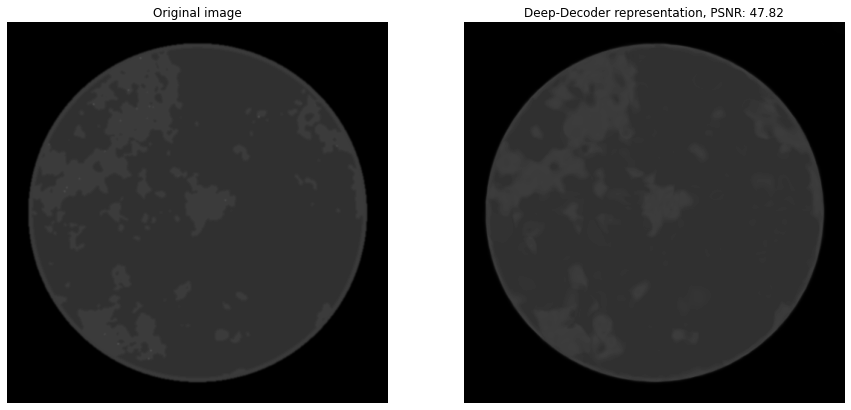

In [12]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print("num GPUs", torch.cuda.device_count())
# dtype = torch.FloatTensor

x_np = np.expand_dims(x, axis=0)
y_np = np.expand_dims(y, axis=0)


# compute representations
psnrv, out_img_np, nparms = run(x_np, y_np, 64)

print("Compression factor: ", np.prod(x_np.shape) / nparms)
# plot results
fig = plt.figure(figsize=(15, 15))  # create a 5 x 5 figure

ax1 = fig.add_subplot(121)
plt.imshow(x_np.squeeze(), vmin=0, vmax=1, cmap='gray')
ax1.set_title('Original image')
ax1.axis('off')

ax2 = fig.add_subplot(122)
plt.imshow(out_img_np[0].squeeze(), vmin=0, vmax=1, cmap='gray')
ax2.set_title("Deep-Decoder representation, PSNR: %.2f" % psnrv)
ax2.axis('off')

plt.axis('off')
fig.savefig("result.png")